In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, plot_confusion_matrix

# Ex. 7

In [115]:
dataset_file = '../datasets/Boston.csv'
seed = 1

data = pd.read_csv(dataset_file)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [116]:
train_data, test_data = train_test_split(data, test_size=.25, random_state=seed)

train_X, test_X = train_data.drop(['medv'], axis=1), test_data.drop(['medv'], axis=1)
train_y, test_y = train_data.medv, test_data.medv

In [117]:
%%time
trees_nums = np.array([1, 5, 10, 25, 50, 100, 250, 500])
vars_nums = np.array([1, 3, 5, 7, 9, 11, 13])
errors = pd.DataFrame(index=trees_nums, columns=vars_nums)

for vars_num in vars_nums:
    for trees_num in trees_nums:
        model = ensemble.RandomForestRegressor(
            random_state=seed,
            n_estimators=trees_num,
            max_features=vars_num
        )
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X)

        errors.loc[trees_num, vars_num] = mean_squared_error(test_y, pred_y)

CPU times: user 11 s, sys: 19.9 ms, total: 11.1 s
Wall time: 11 s


Text(0, 0.5, 'MSE')

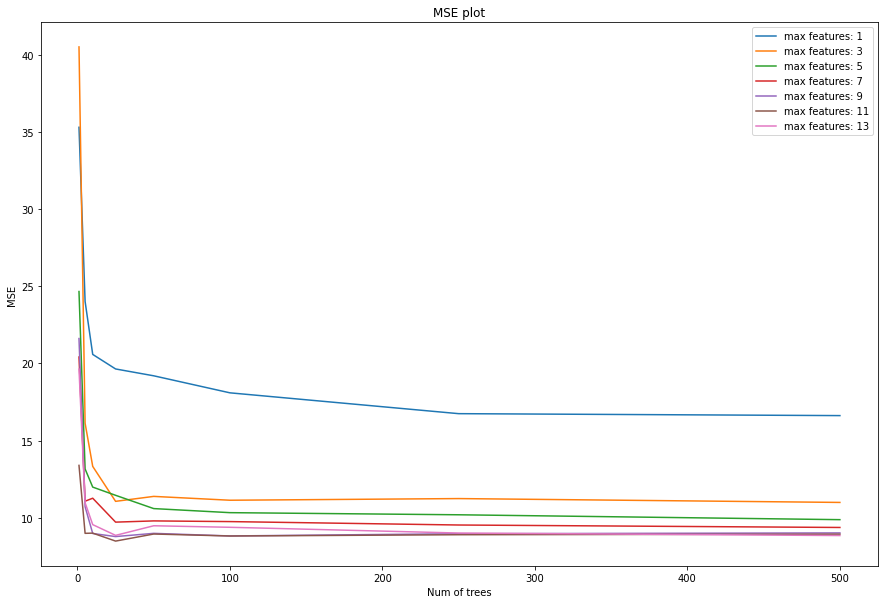

In [118]:
fig, ax = plt.subplots(figsize=(15,10))
for col in errors.columns:
    ax.plot(errors.index, errors[col], label=f'max features: {col}')
ax.legend()
ax.set_title('MSE plot')
ax.set_xlabel('Num of trees')
ax.set_ylabel('MSE')

The plot shows that 100 trees is sufficient to get best results from random forest. Also models that consider 9 and 11 features at each split perform best.

# Ex. 8

In [119]:
dataset_file = '../datasets/Carseats.csv'

data = pd.read_csv(dataset_file)
data.Urban = data.Urban.apply(lambda v: 1 if v == 'Yes' else 0)
data.US = data.US.apply(lambda v: 1 if v == 'Yes' else 0)
data = pd.concat([data, pd.get_dummies(data.ShelveLoc, prefix='ShelveLoc', prefix_sep='')], axis=1)
data.drop(['ShelveLoc'], axis=1, inplace=True)
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,ShelveLocBad,ShelveLocGood,ShelveLocMedium
0,9.50,138,73,11,276,120,42,17,1,1,1,0,0
1,11.22,111,48,16,260,83,65,10,1,1,0,1,0
2,10.06,113,35,10,269,80,59,12,1,1,0,0,1
3,7.40,117,100,4,466,97,55,14,1,1,0,0,1
4,4.15,141,64,3,340,128,38,13,1,0,1,0,0


In [120]:
train_data, test_data = train_test_split(data, test_size=.25, random_state=seed)

train_X, test_X = train_data.drop(['Sales'], axis=1), test_data.drop(['Sales'], axis=1)
train_y, test_y = train_data.Sales, test_data.Sales

In [121]:
model = tree.DecisionTreeRegressor(random_state=seed).fit(train_X, train_y)

Terminal nodes: 295
Training error: 0.0000
Test error: 5.9852
Mean deviance: 0.0000


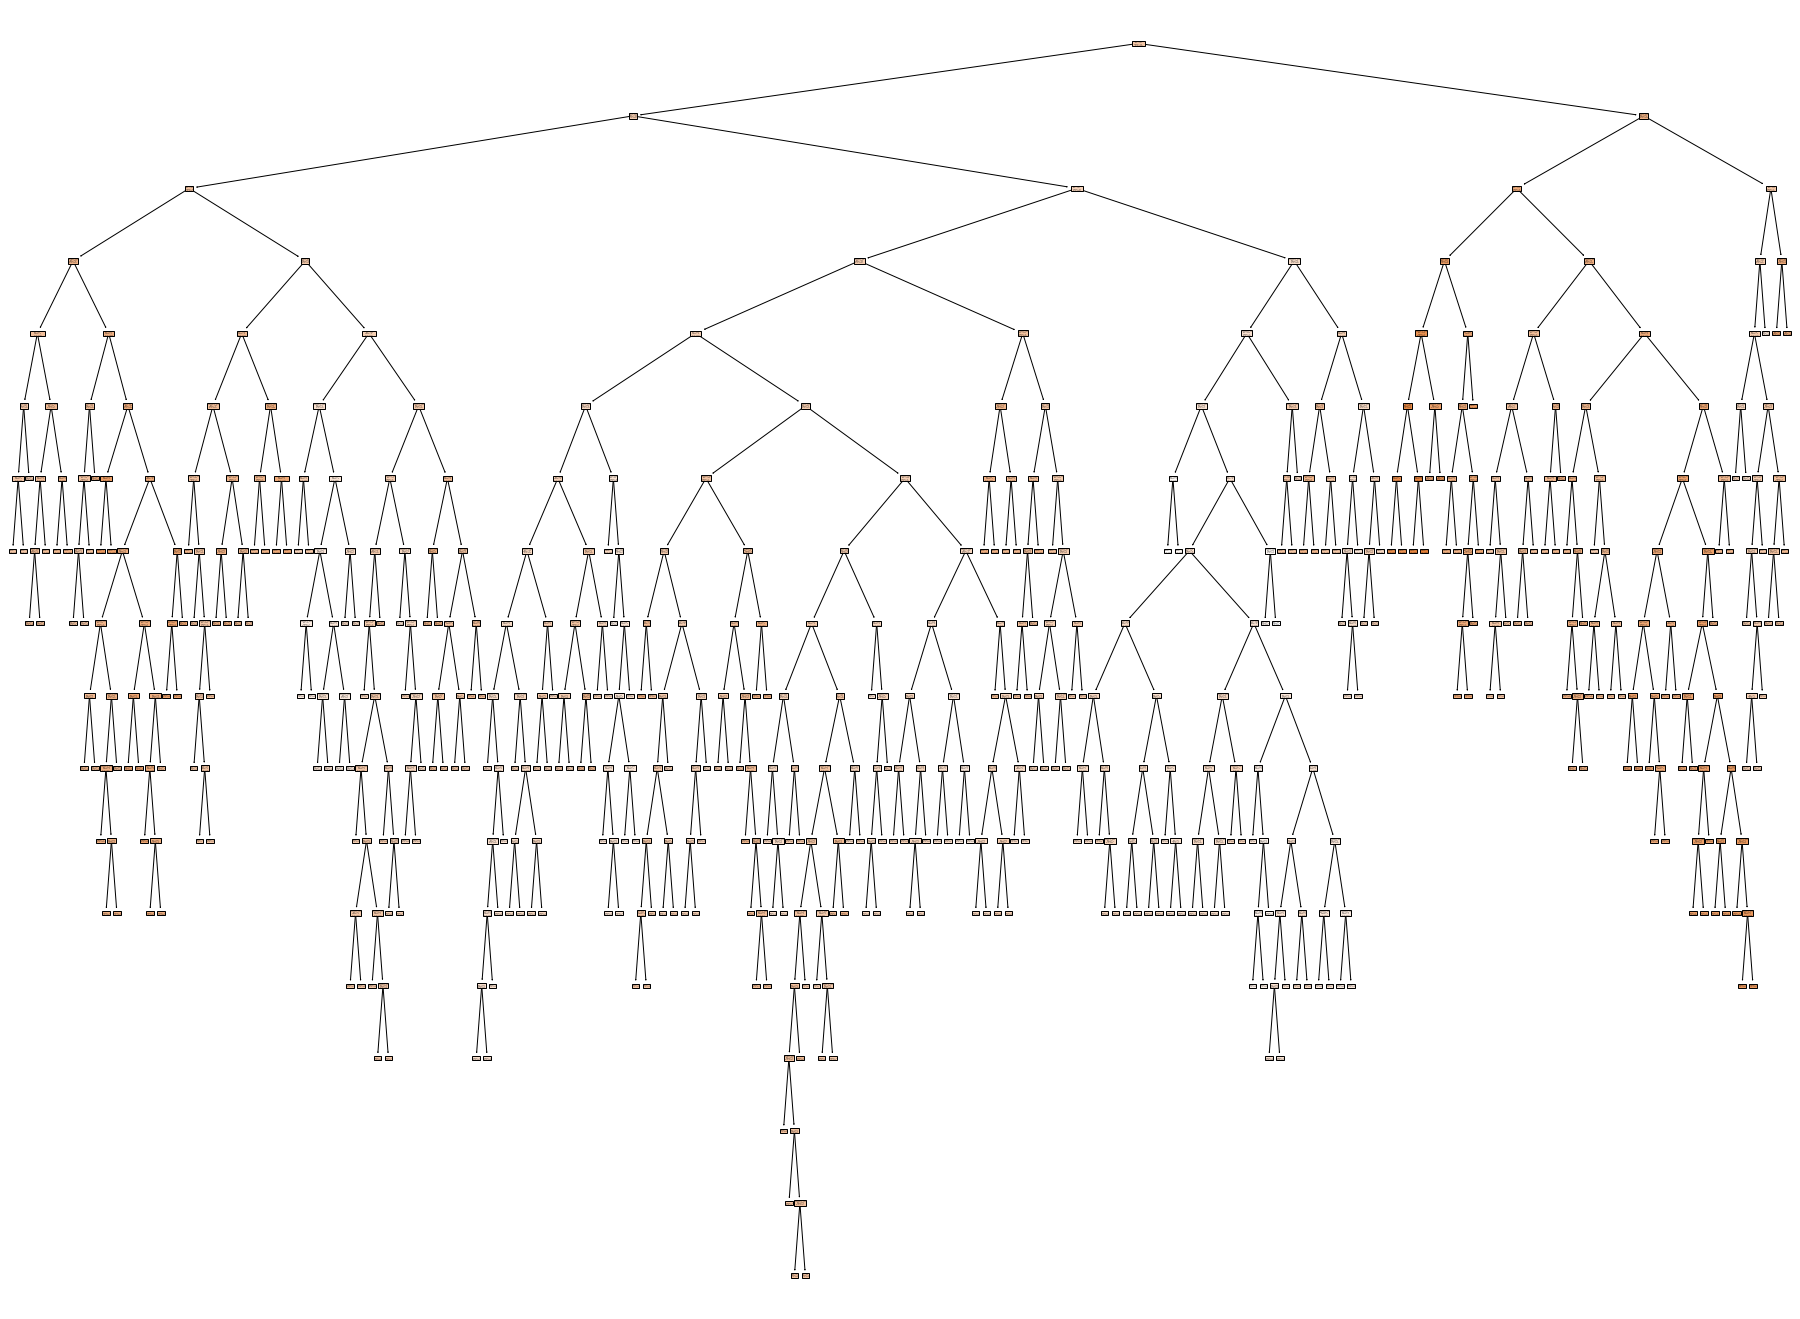

In [122]:
plt.figure(figsize=(32, 24))
cols = train_X.columns
tree.plot_tree(model, feature_names=cols, filled=True)

deviance = ((train_y - model.predict(train_X)) ** 2).sum()
print(f'Terminal nodes: {model.get_n_leaves()}')
print(f"Training error: {mean_squared_error(train_y, model.predict(train_X)):.4f}")
print(f"Test error: {mean_squared_error(test_y, model.predict(test_X)):.4f}")
print(f"Mean deviance: {deviance / (train_y.size - model.get_n_leaves()):.4f}")

In [123]:
def mse_scoring(est, X, y):
    return mean_squared_error(y, est.predict(X))

Text(0, 0.5, 'MSE')

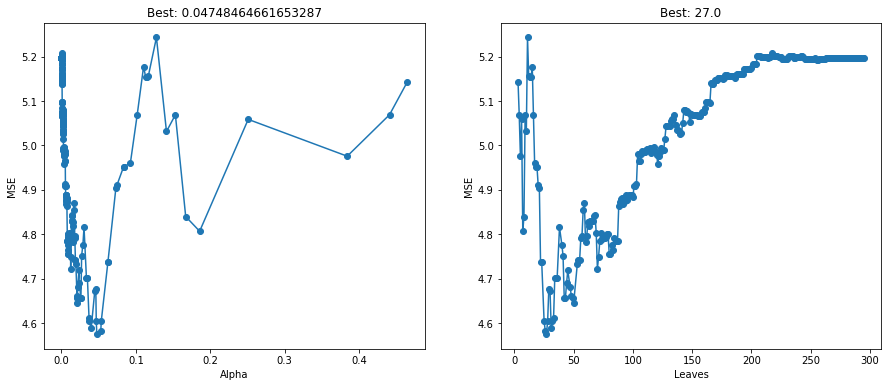

In [124]:
alphas = model.cost_complexity_pruning_path(train_X, train_y)['ccp_alphas'][:-2]
train_scores = pd.DataFrame(
    dtype=float,
    index=pd.RangeIndex(len(alphas)),
    columns=['alpha', 'mean', 'std', 'leaves']
)
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

for idx, alpha in enumerate(alphas):
    model = tree.DecisionTreeRegressor(random_state=seed, ccp_alpha=alpha)
    model.fit(train_X, train_y)
    leaves = model.get_n_leaves()
    scores = cross_val_score(model, train_X, train_y, scoring=mse_scoring, cv=cv)
    train_scores.iloc[idx] = alpha, scores.mean(), scores.std(), leaves

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
best = train_scores['mean'].idxmin()

axes[0].plot(train_scores.alpha, train_scores['mean'], 'o-')
axes[0].set_title(f"Best: {train_scores.iloc[best].alpha}")
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('MSE')

axes[1].plot(train_scores.leaves, train_scores['mean'], 'o-')
axes[1].set_title(f"Best: {train_scores.loc[best].leaves}")
axes[1].set_xlabel('Leaves')
axes[1].set_ylabel('MSE')

MSE: 5.4689
Leaves: 27


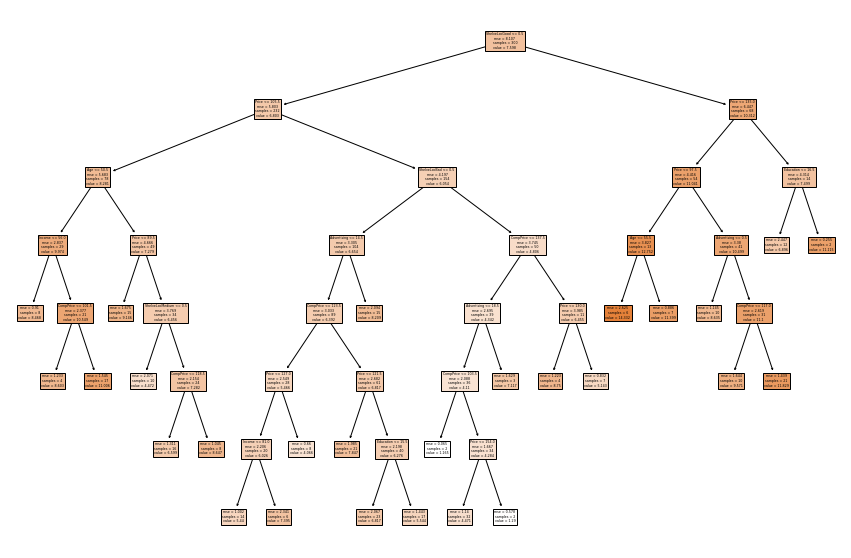

In [125]:
best_model = tree.DecisionTreeRegressor(random_state=seed, ccp_alpha=train_scores.iloc[best].alpha)
best_model.fit(train_X, train_y)
pred_y = best_model.predict(test_X)

mse = mean_squared_error(test_y, pred_y)

plt.figure(figsize=(15, 10))
tree.plot_tree(best_model, feature_names=cols, filled=True)

print(f'MSE: {mse:.4f}')
print(f'Leaves: {best_model.get_n_leaves()}')

Test MSE has improved slightly.

MSE: 2.8704


Text(0.5, 1.0, 'Feature importances')

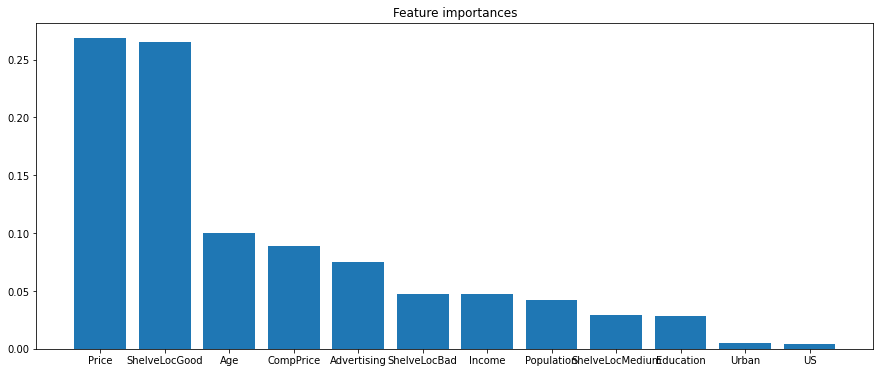

In [126]:
model = ensemble.BaggingRegressor(random_state=seed, n_estimators=100)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

mse = mean_squared_error(test_y, pred_y)

print(f'MSE: {mse:.4f}')

importances = np.mean([tree.feature_importances_ for tree in model.estimators_], axis=0)
importances_s = pd.Series({col: importances[i] for i, col in enumerate(train_X.columns)})
importances_s.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(importances_s.index, importances_s)
ax.set_title('Feature importances')

Test MSE has decreased dramatically.

In [127]:
vars_nums = np.arange(1, train_X.shape[1] + 1)
errors = pd.Series(index=vars_nums, dtype=float)

for vars_num in vars_nums:
    model = ensemble.RandomForestRegressor(
        random_state=seed,
        n_estimators=100,
        max_features=vars_num
    )
    model.fit(train_X, train_y)
    pred_y = model.predict(test_X)

    errors.loc[vars_num] = mean_squared_error(test_y, pred_y)

Text(0, 0.5, 'MSE')

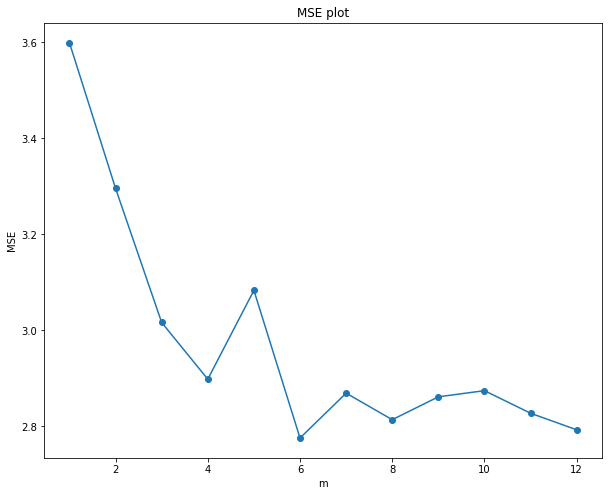

In [128]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(errors.index, errors, 'o-')
ax.set_title('MSE plot')
ax.set_xlabel('m')
ax.set_ylabel('MSE')

Mse differs for different number of max features, but has a tendention to go down with increasing of number of features. Lowest MSE belongs to model with 6 features.

MSE: 2.7756


Text(0.5, 1.0, 'Feature importances')

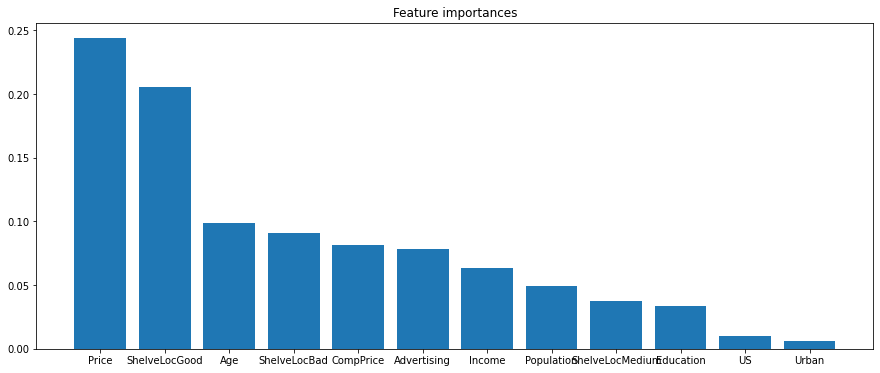

In [129]:
model = ensemble.RandomForestRegressor(random_state=seed, n_estimators=100, max_features=6)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

mse = mean_squared_error(test_y, pred_y)

print(f'MSE: {mse:.4f}')

importances = pd.Series({col: model.feature_importances_[i] for i, col in enumerate(train_X.columns)})
importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(importances.index, importances)
ax.set_title('Feature importances')

Random forest has slightly decreased test MSE compared to bagging.

# Ex. 9

In [130]:
dataset_file = '../datasets/OJ.csv'

data = pd.read_csv(dataset_file)
data.Store7 = data.Store7.apply(lambda v: 1 if v == 'Yes' else 0)
data = pd.concat([data, pd.get_dummies(data.Purchase, prefix='Purchase', prefix_sep='')], axis=1)
data.drop(['Purchase', 'PurchaseMM'], axis=1, inplace=True)
data = pd.concat([data, pd.get_dummies(data.StoreID, prefix='StoreID', prefix_sep='')], axis=1)
data.drop(['STORE', 'StoreID', 'Store7'], axis=1, inplace=True)
data.head()

,WeekofPurchase,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff,PurchaseCH,StoreID1,StoreID2,StoreID3,StoreID4,StoreID7
0,237,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0.000000,0.000000,0.24,1,1,0,0,0,0
1,239,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0.150754,0.000000,0.24,1,1,0,0,0,0
2,245,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0.000000,0.091398,0.23,1,1,0,0,0,0
3,227,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0.000000,0.000000,0.00,0,1,0,0,0,0
4,228,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,0.000000,0.000000,0.00,1,0,0,0,0,1


In [131]:
train_data, test_data = train_test_split(data, train_size=800, random_state=seed)

train_X, test_X = train_data.drop(['PurchaseCH'], axis=1), test_data.drop(['PurchaseCH'], axis=1)
train_y, test_y = train_data.PurchaseCH, test_data.PurchaseCH

In [132]:
model = tree.DecisionTreeClassifier(random_state=seed).fit(train_X, train_y)

In [133]:
from collections import Counter

leaves_count = Counter()
n1 = Counter()
n0 = Counter()
for X, y in zip(train_X.to_numpy(), train_y):
    terminal = model.apply(X.reshape(1, -1))[0]
    leaves_count[terminal] += 1
    if y == 1:
        n1[terminal] += 1
    else:
        n0[terminal] += 1

deviance = -2 * np.sum([n1[leaf] * np.log(n1[leaf] / leaves_count[leaf] + 1e-6) + \
                        n0[leaf] * np.log(n0[leaf] / leaves_count[leaf] + 1e-6) 
                        for leaf in leaves_count.keys()])

Terminal nodes: 159
Training error: 0.0100
Mean deviance: 0.0379


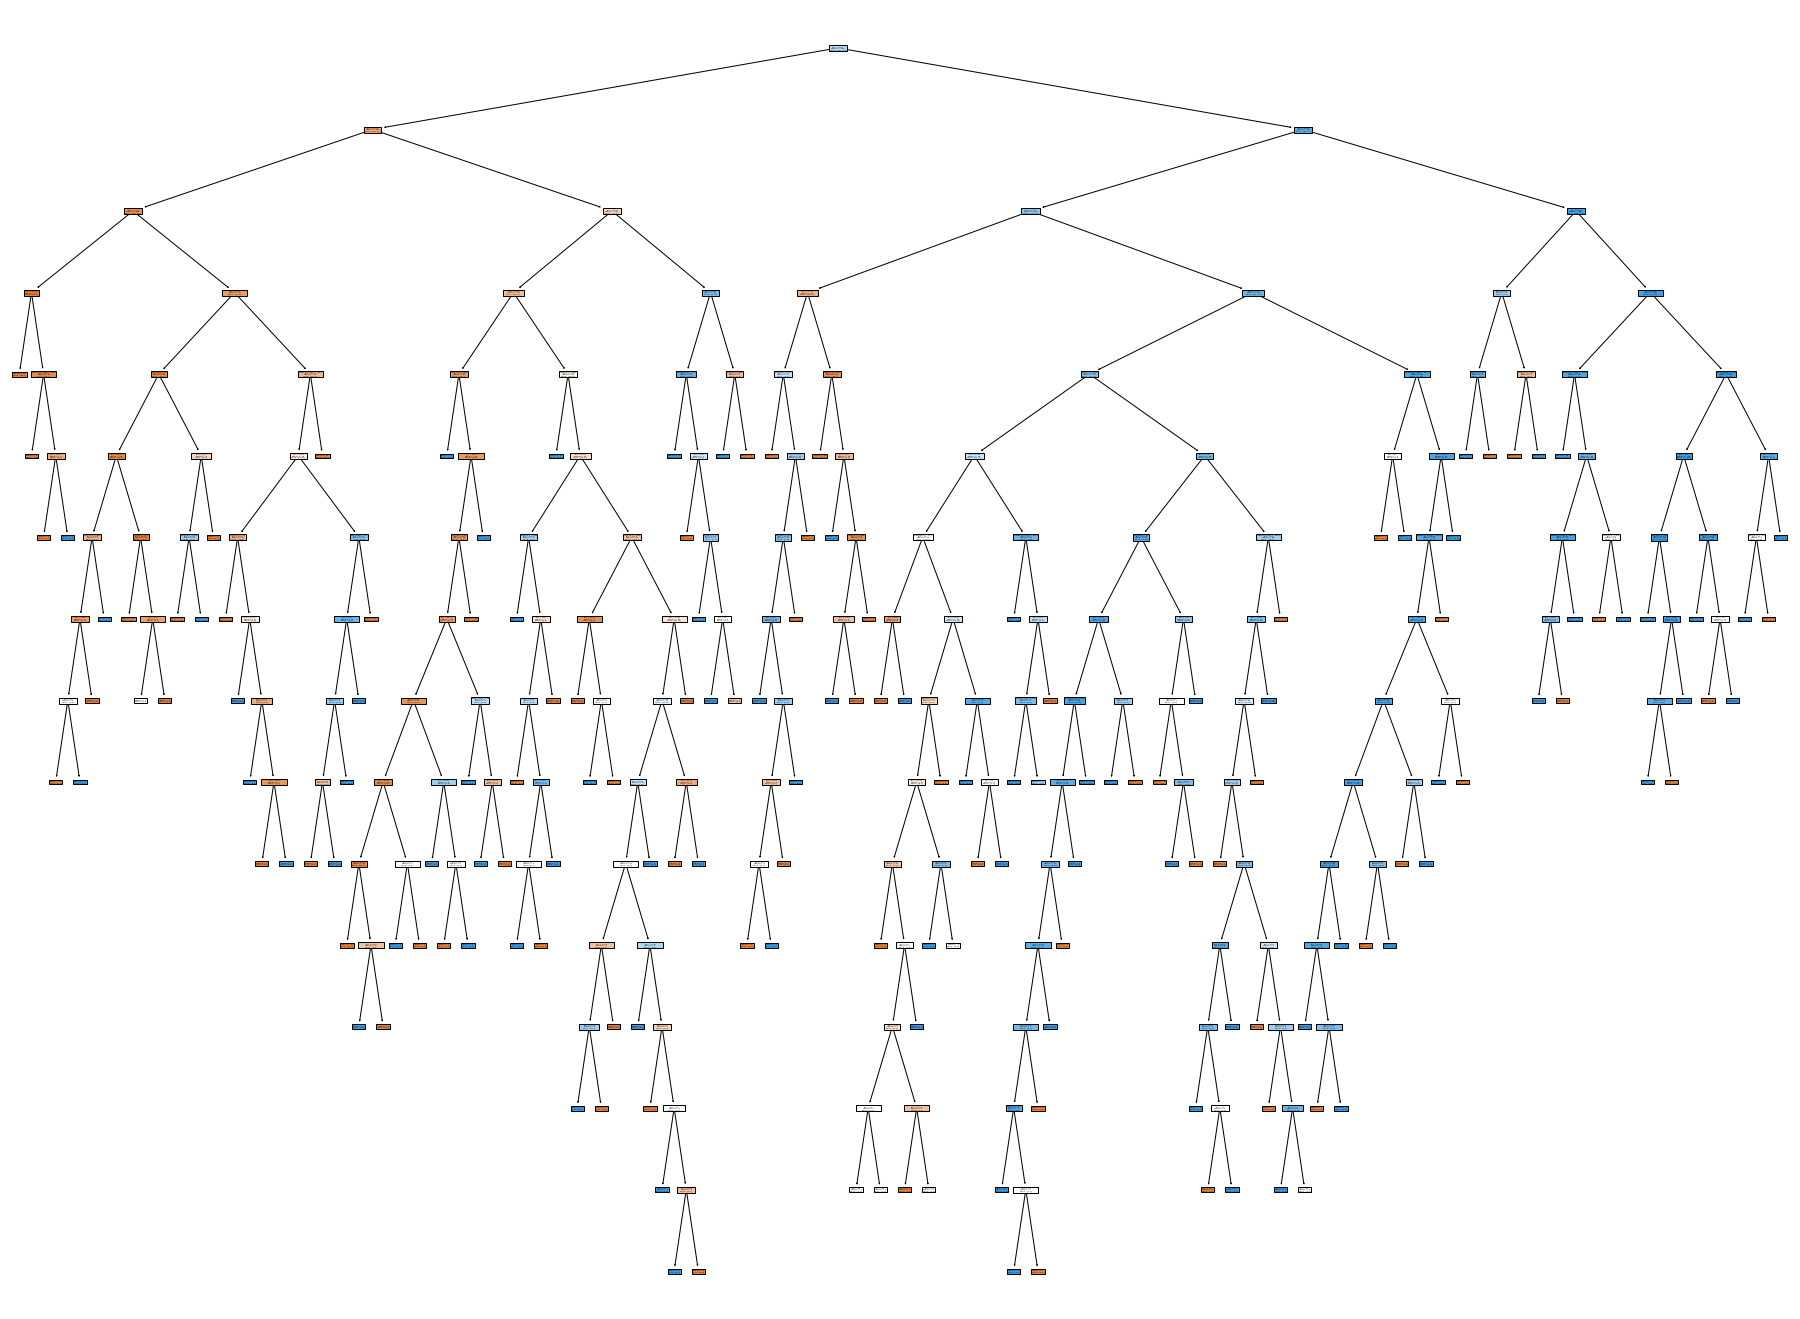

In [134]:
plt.figure(figsize=(32, 24))
cols = train_X.columns
tree.plot_tree(model, feature_names=cols, filled=True)

print(f'Terminal nodes: {model.get_n_leaves()}')
print(f"Training error: {1 - model.score(train_X, train_y):.4f}")
print(f"Mean deviance: {deviance / (train_y.size - model.get_n_leaves()):.4f}")

In [135]:
print(tree.export_text(model, feature_names=list(cols)))

|--- LoyalCH <= 0.45
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.05
|   |   |   |--- StoreID2 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- StoreID2 >  0.50
|   |   |   |   |--- WeekofPurchase <= 268.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- WeekofPurchase >  268.00
|   |   |   |   |   |--- LoyalCH <= 0.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- LoyalCH >  0.00
|   |   |   |   |   |   |--- class: 1
|   |   |--- LoyalCH >  0.05
|   |   |   |--- WeekofPurchase <= 249.50
|   |   |   |   |--- StoreID1 <= 0.50
|   |   |   |   |   |--- LoyalCH <= 0.09
|   |   |   |   |   |   |--- LoyalCH <= 0.08
|   |   |   |   |   |   |   |--- LoyalCH <= 0.07
|   |   |   |   |   |   |   |   |--- LoyalCH <= 0.06
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- LoyalCH >  0.06
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- LoyalCH >  0.07
|   |   |   |   |   |   |   |   |--- class: 

The simplest node suggests that if LoyalCH <= 0.05 and StoreID is not 2, then target class is MM.

Train error rate: 0.010
Test error rate: 0.244


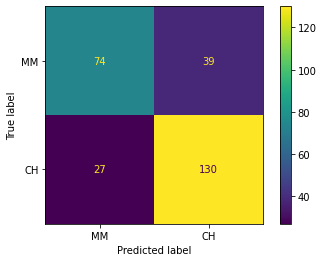

In [136]:
train_acc = model.score(train_X, train_y)
test_acc = model.score(test_X, test_y)
print(f'Train error rate: {1 - train_acc:.3f}')
print(f'Test error rate: {1 - test_acc:.3f}')
plot_confusion_matrix(model, test_X, test_y, display_labels=['MM', 'CH'])

Text(0, 0.5, 'Error')

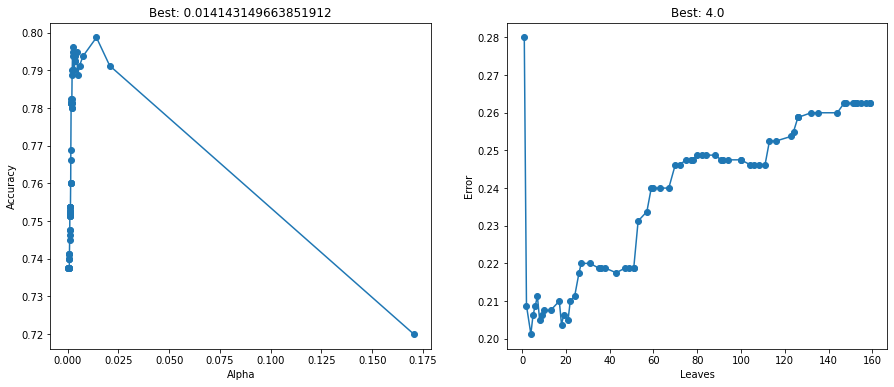

In [137]:
alphas = model.cost_complexity_pruning_path(train_X, train_y)['ccp_alphas']
train_scores = pd.DataFrame(
    dtype=float,
    index=pd.RangeIndex(len(alphas)),
    columns=['alpha', 'mean', 'std', 'leaves']
)
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

for idx, alpha in enumerate(alphas):
    model = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=alpha)
    model.fit(train_X, train_y)
    leaves = model.get_n_leaves()
    scores = cross_val_score(model, train_X, train_y, cv=cv)
    train_scores.iloc[idx] = alpha, scores.mean(), scores.std(), leaves

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
best = train_scores['mean'].idxmax()

axes[0].plot(train_scores.alpha, train_scores['mean'], 'o-')
axes[0].set_title(f"Best: {train_scores.iloc[best].alpha}")
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Accuracy')

axes[1].plot(train_scores.leaves, 1 - train_scores['mean'], 'o-')
axes[1].set_title(f"Best: {train_scores.loc[best].leaves}")
axes[1].set_xlabel('Leaves')
axes[1].set_ylabel('Error')

Train error rate: 0.165
Test error rate: 0.181
Leaves: 4


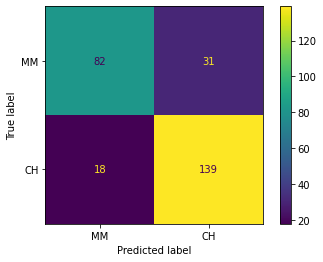

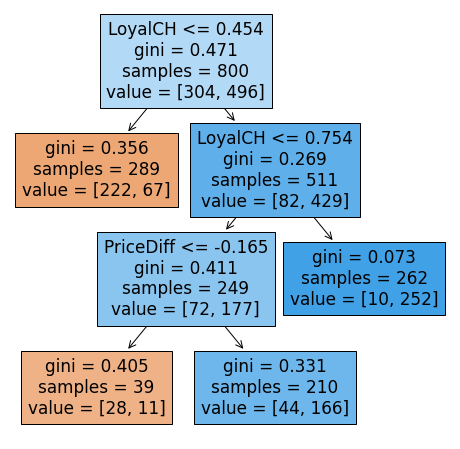

In [138]:
best_model = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=train_scores.iloc[best].alpha)
best_model.fit(train_X, train_y)
pred_y = best_model.predict(test_X)

plot_confusion_matrix(best_model, test_X, test_y, display_labels=['MM', 'CH'])
plt.figure(figsize=(8, 8))
tree.plot_tree(best_model, feature_names=cols, filled=True)

train_acc = best_model.score(train_X, train_y)
test_acc = best_model.score(test_X, test_y)
print(f'Train error rate: {1 - train_acc:.3f}')
print(f'Test error rate: {1 - test_acc:.3f}')
print(f'Leaves: {best_model.get_n_leaves()}')

Pruned Tree has higher train error, but lower test error.

# Ex. 10

In [139]:
dataset_file = '../datasets/Hitters.csv'

data = pd.read_csv(dataset_file, index_col=0)
data.dropna(inplace=True)
data['LeagueN'] = data.League.apply(lambda v: 1 if v == 'N' else 0)
data['DivisionW'] = data.Division.apply(lambda v: 1 if v == 'W' else 0)
data['NewLeagueN'] = data.NewLeague.apply(lambda v: 1 if v == 'N' else 0)
data.drop(['League', 'Division', 'NewLeague'], axis=1, inplace=True)
data.Salary = data.Salary.apply(np.log)
data.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,LeagueN,DivisionW,NewLeagueN
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,6.163315,1,1,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,6.173786,0,1,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,6.214608,1,0,1
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,4.516339,1,0,1
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,6.620073,0,1,0


In [140]:
train_data, test_data = train_test_split(data, train_size=200, random_state=seed)

train_X, test_X = train_data.drop(['Salary'], axis=1), test_data.drop(['Salary'], axis=1)
train_y, test_y = train_data.Salary, test_data.Salary

CPU times: user 26.5 s, sys: 71.9 ms, total: 26.5 s
Wall time: 26.5 s


Text(0.5, 1.0, 'Best lambda: 0.0206913808111479')

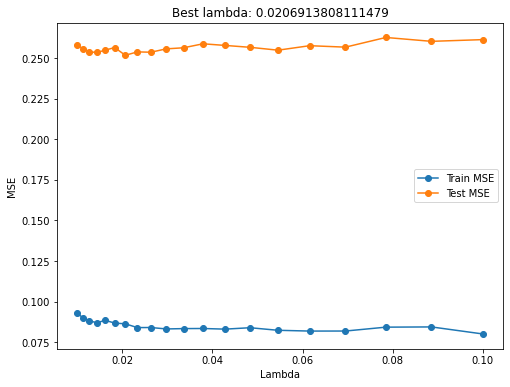

In [141]:
%%time
lambdas = np.logspace(-2, -1, 20)
errors = pd.DataFrame(index=lambdas, columns=['train', 'test'], dtype=float)
for lam in lambdas:
    model = ensemble.AdaBoostRegressor(n_estimators=1000, learning_rate=lam, random_state=seed)
    model.fit(train_X, train_y)
    train_mse = mean_squared_error(train_y, model.predict(train_X))
    test_mse = mean_squared_error(test_y, model.predict(test_X))
    errors.loc[lam] = train_mse, test_mse

best_lambda = errors.test.idxmin()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(errors.index, errors.train, 'o-', label='Train MSE')
ax.plot(errors.index, errors.test, 'o-', label='Test MSE')
ax.legend()
ax.set_xlabel('Lambda')
ax.set_ylabel('MSE')
ax.set_title(f'Best lambda: {best_lambda}')

In [142]:
print(f'Boosting MSE: {errors.test.min():.4f}')

Boosting MSE: 0.2518


In [3]:
from itertools import combinations
from concurrent.futures import ProcessPoolExecutor, as_completed
import statsmodels.api as sm

def test_k(X, y, k):
    models = [(names, sm.OLS(y, sm.add_constant(X[list(names)])).fit().rsquared) for names in combinations(X.columns, k)]
    return k, max(models, key=lambda model: model[1])[0]

def best_subset_selection(X, y, max_jobs=None, verbose=True):
    p = X.shape[1]
    best_of_k = {}
    best_of_k[0] = []
    
    with ProcessPoolExecutor(max_workers=max_jobs) as executor:
        
        futures = [executor.submit(test_k, X, y, k) for k in range(1, p + 1)]
        for future in as_completed(futures):
            best_of_k[future.result()[0]] = future.result()[1]
            if verbose:
                print(future.result()[0], future.result()[1])
        
    return best_of_k

In [144]:
def evaluate(best_of_k, X, y):
    metrics = pd.DataFrame(columns=['RSS', 'R_squared_adj', 'AIC', 'BIC'])

    for k, names in best_of_k.items():
        if k == 0:
            model = sm.OLS(y, np.ones(y.shape)).fit()
        else:
            model = sm.OLS(y, sm.add_constant(X[list(names)])).fit()
        metrics.loc[k] = [model.ssr, model.rsquared_adj, model.aic, model.bic]
    metrics.sort_index(inplace=True)

    _, axes = plt.subplots(2, 2, figsize=(10, 10))
    for i, col in enumerate(metrics.columns):
        sns.pointplot(metrics.index, metrics[col], marker='o', ax=axes[i%2, i//2], label=col,)
        best = metrics[col].argmax() if col == 'R_squared_adj' else metrics[col].argmin()
        axes[i%2, i//2].set_title(f'Best: {best}')
        sns.scatterplot([best], [metrics[col][best]], marker='o', s=200, color='m', ax=axes[i%2, i//2])

In [145]:
%%time
best_models = best_subset_selection(train_X, train_y)

1 ('CHits',)
2 ('Hits', 'Years')
3 ('Hits', 'Years', 'PutOuts')
4 ('Hits', 'Walks', 'Years', 'PutOuts')
5 ('Hits', 'Walks', 'Years', 'PutOuts', 'DivisionW')
6 ('Hits', 'Walks', 'Years', 'CRBI', 'PutOuts', 'DivisionW')
14 ('AtBat', 'Hits', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRBI', 'CWalks', 'PutOuts', 'LeagueN', 'DivisionW')
13 ('AtBat', 'Hits', 'RBI', 'Walks', 'Years', 'CHits', 'CHmRun', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'LeagueN', 'DivisionW')
16 ('AtBat', 'Hits', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'LeagueN', 'DivisionW', 'NewLeagueN')
17 ('AtBat', 'Hits', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'LeagueN', 'DivisionW', 'NewLeagueN')
18 ('AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'LeagueN', 'DivisionW', 'NewLeagueN')
19 ('

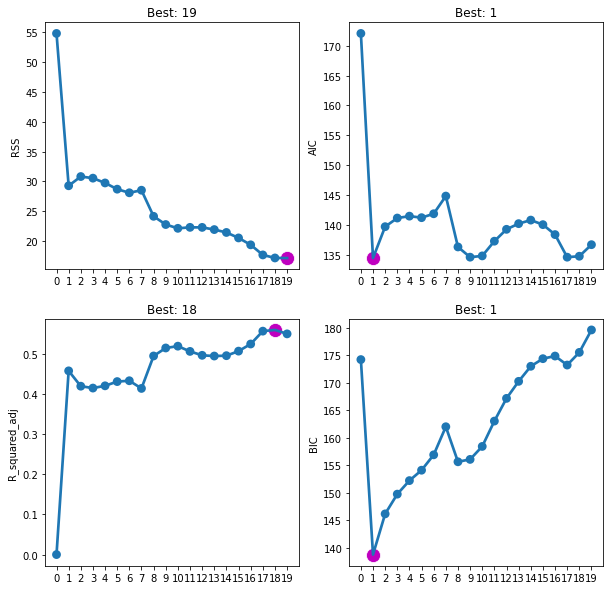

In [146]:
evaluate(best_models, test_X, test_y)

In [4]:
from sklearn.linear_model import Ridge, LinearRegression

In [148]:
bss_model = LinearRegression().fit(train_X[list(best_models[18])], train_y)
bss_mse = mean_squared_error(test_y, bss_model.predict(test_X[list(best_models[18])]))
print(f'BSS MSE: {bss_mse:.4f}')

BSS MSE: 0.4529


In [149]:
X = train_X / train_X.std()
lambdas = np.logspace(1, 2.5, 20).round(3)
cv = KFold(n_splits=10, shuffle=True, random_state=seed)
res = pd.Series(index=lambdas, dtype=np.float64)
for l in lambdas:
    lambda_res = []
    for train, test in cv.split(X):
        model = Ridge(alpha=l, normalize=False, max_iter=2000).fit(X.iloc[train], train_y.iloc[train])
        lambda_res.append(mean_squared_error(train_y.iloc[test], model.predict(X.iloc[test])))
    res.loc[l] = np.mean(lambda_res)

106.247


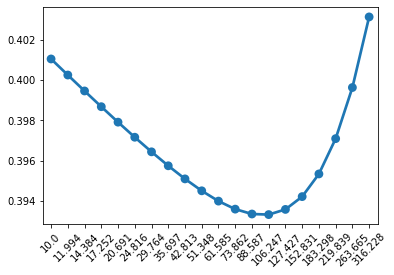

In [150]:
ax = sns.pointplot(res.index, res)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
best = res.idxmin()
print(best)

In [151]:
ridge_model = Ridge(alpha=best, normalize=False, max_iter=2000).fit(train_X / train_X.std(), train_y)
ridge_mse = mean_squared_error(test_y, ridge_model.predict(test_X / test_X.std()))
print(f'Ridge MSE: {ridge_mse:.4f}')

Ridge MSE: 0.4675


Boosting outperforms both Ridge regression and Best Subset Selection model.

Text(0.5, 1.0, 'Feature importances')

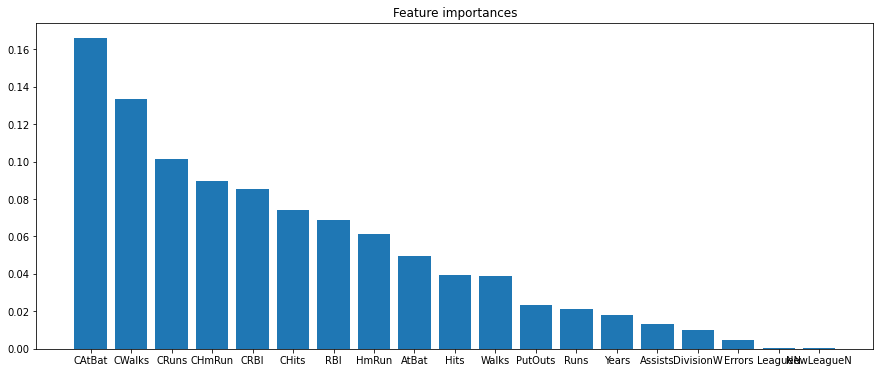

In [152]:
boosting_model = ensemble.AdaBoostRegressor(n_estimators=1000, learning_rate=best_lambda, random_state=seed)
boosting_model.fit(train_X, train_y)   

importances = pd.Series({col: boosting_model.feature_importances_[i] for i, col in enumerate(train_X.columns)})
importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(importances.index, importances)
ax.set_title('Feature importances')

In [153]:
bagging_model = ensemble.BaggingRegressor(n_estimators=1000, random_state=seed)
bagging_model.fit(train_X, train_y)   

mse = mean_squared_error(test_y, bagging_model.predict(test_X))
print(f'Bagging MSE: {mse:.4f}')

Bagging MSE: 0.2478


Bagging has the best score.

# Ex. 11

In [26]:
dataset_file = '../datasets/Caravan.csv'
seed = 1

data = pd.read_csv(dataset_file)
data.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


In [21]:
data_encoded = pd.DataFrame(index = data.index)
for col in data.columns:
    if col == 'MOSTYPE':
        data_encoded['MOSTYPE'] = data['MOSTYPE']
        continue
    data_encoded = pd.concat([data_encoded, pd.get_dummies(data[col], prefix=col, prefix_sep='')], axis=1)
data_encoded.drop(['PurchaseNo'], axis=1, inplace=True)
data_encoded

,MOSTYPE,MAANTHUI1,MAANTHUI2,MAANTHUI3,MAANTHUI4,MAANTHUI5,MAANTHUI6,MAANTHUI7,MAANTHUI8,MAANTHUI10,...,AFIETS1,AFIETS2,AFIETS3,AINBOED0,AINBOED1,AINBOED2,ABYSTAND0,ABYSTAND1,ABYSTAND2,PurchaseYes
0,33,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,37,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,37,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,9,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,40,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
5818,35,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
5819,33,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
5820,34,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [25]:
train_data, test_data = train_test_split(data_encoded, train_size=1000, shuffle=False)

train_X, test_X = train_data.drop(['PurchaseYes'], axis=1), test_data.drop(['PurchaseYes'], axis=1)
train_y, test_y = train_data.PurchaseYes, test_data.PurchaseYes

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

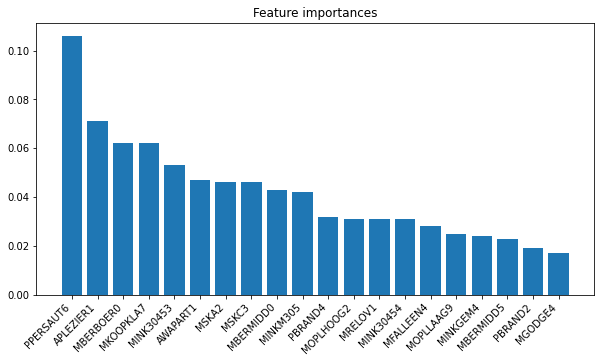

In [39]:
model = ensemble.AdaBoostClassifier(n_estimators=1000, learning_rate=0.01, random_state=seed)
model.fit(train_X, train_y)

importances = pd.Series({col: model.feature_importances_[i] for i, col in enumerate(train_X.columns)})
importances.sort_values(ascending=False, inplace=True)
importances = importances[:20]

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(importances.index, importances)
ax.set_title('Feature importances')
plt.xticks(rotation=45, horizontalalignment='right')

In [61]:
pred_y = model.predict_proba(test_X)[:, 1] > 0.2

cmx = confusion_matrix(test_y, pred_y).T
acc = accuracy_score(test_y, pred_y)

print(f'TN: {cmx[0, 0]}, FN: {cmx[0, 1]}, FP: {cmx[1, 0]}, TP: {cmx[1, 1]}')
print(f'{100 * cmx[1, 1] / (cmx[1, 0] + cmx[1, 1]):.2f}% of the people predicted to make a purchase in fact make one')
print(f'Accuracy score: {acc:.4f}')

TN: 0, FN: 0, FP: 4533, TP: 289
5.99% of the people predicted to make a purchase in fact make one
Accuracy score: 0.0599


In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [55]:
knn_model = KNeighborsClassifier().fit(train_X, train_y)
pred_y = knn_model.predict_proba(test_X)[:, 1] > 0.2

cmx = confusion_matrix(test_y, pred_y).T
acc = accuracy_score(test_y, pred_y)

print(f'TN: {cmx[0, 0]}, FN: {cmx[0, 1]}, FP: {cmx[1, 0]}, TP: {cmx[1, 1]}')
print(f'KNN precision {cmx[1, 1] / (cmx[1, 0] + cmx[1, 1]):.2f}')
print(f'KNN accuracy score: {acc:.4f}')

TN: 4316, FN: 258, FP: 217, TP: 31
KNN precision 0.12
KNN accuracy score: 0.9015


In [56]:
logreg_model = KNeighborsClassifier().fit(train_X, train_y)
pred_y = logreg_model.predict_proba(test_X)[:, 1] > 0.2

cmx = confusion_matrix(test_y, pred_y).T
acc = accuracy_score(test_y, pred_y)

print(f'TN: {cmx[0, 0]}, FN: {cmx[0, 1]}, FP: {cmx[1, 0]}, TP: {cmx[1, 1]}')
print(f'LogReg precision {cmx[1, 1] / (cmx[1, 0] + cmx[1, 1]):.2f}')
print(f'LogReg accuracy score: {acc:.4f}')

TN: 4316, FN: 258, FP: 217, TP: 31
LogReg precision 0.12
LogReg accuracy score: 0.9015


In [68]:
from sklearn.metrics import roc_curve, roc_auc_score

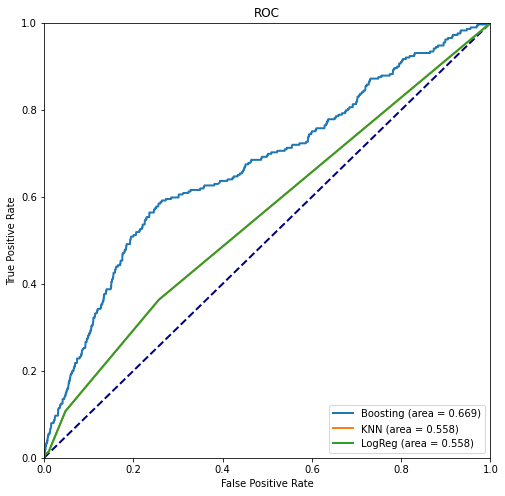

In [97]:
scores = [
    ('Boosting', model.predict_proba(test_X)[:, 1]),
    ('KNN', knn_model.predict_proba(test_X)[:, 1]),
    ('LogReg', logreg_model.predict_proba(test_X)[:, 1])
]

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

for name, score in scores:
    fpr, tpr, thr = roc_curve(test_y, score)
    roc_auc = roc_auc_score(test_y, score)
    ax.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.3f})')
ax.legend(loc="lower right")    

Boosting model with 20% threshold has less precision then KNN and logistic regression model and also has very bad accuracy.

# Ex. 12

In [108]:
from sklearn.metrics import precision_score

In [144]:
dataset_file = '../datasets/Credit.csv'

data = pd.read_csv(dataset_file, index_col='ID')
data.Married = data.Married.apply(lambda v: 1 if v == 'Yes' else 0)
data.Student = data.Student.apply(lambda v: 1 if v == 'Yes' else 0)
data = pd.concat([data, pd.get_dummies(data.Ethnicity), pd.get_dummies(data.Gender)], axis=1)
data['GoodRating'] = (data.Rating > data.Rating.mean()).astype(int)
data.drop(['Gender', 'Ethnicity', 'Rating', ' Male', 'Caucasian'], axis=1, inplace=True)
data.head()

,Income,Limit,Cards,Age,Education,Student,Married,Balance,African American,Asian,Female,GoodRating
ID,,,,,,,,,,,,
1,14.891,3606,2,34,11,0,1,333,0,0,0,0
2,106.025,6645,3,82,15,1,1,903,0,1,1,1
3,104.593,7075,4,71,11,0,0,580,0,1,0,1
4,148.924,9504,3,36,11,0,0,964,0,1,1,1
5,55.882,4897,2,68,16,0,1,331,0,0,0,1


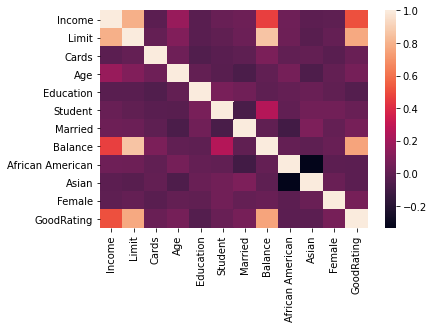

In [145]:
sns.heatmap(data.corr())

In [137]:
train_data, test_data = train_test_split(data, train_size=.25, shuffle=False)

train_X, test_X = train_data.drop(['Approved'], axis=1), test_data.drop(['Approved'], axis=1)
train_y, test_y = train_data.Approved, test_data.Approved

Train error rate: 0.000
Test error rate: 0.033
Test precision: 0.958


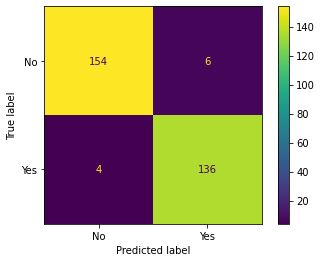

In [138]:
model = ensemble.BaggingClassifier(n_estimators=100, random_state=seed)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

plot_confusion_matrix(model, test_X, test_y, display_labels=['No', 'Yes'])

train_acc = model.score(train_X, train_y)
test_acc = model.score(test_X, test_y)
precision = precision_score(test_y, pred_y)
print(f'Train error rate: {1 - train_acc:.3f}')
print(f'Test error rate: {1 - test_acc:.3f}')
print(f'Test precision: {precision:.3f}')

Train error rate: 0.000
Test error rate: 0.037
Test precision: 0.951


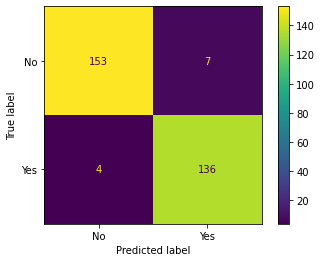

In [169]:
model = ensemble.RandomForestClassifier(max_features=3, n_estimators=100, random_state=seed)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

plot_confusion_matrix(model, test_X, test_y, display_labels=['No', 'Yes'])

train_acc = model.score(train_X, train_y)
test_acc = model.score(test_X, test_y)
precision = precision_score(test_y, pred_y)
print(f'Train error rate: {1 - train_acc:.3f}')
print(f'Test error rate: {1 - test_acc:.3f}')
print(f'Test precision: {precision:.3f}')

Train error rate: 0.000
Test error rate: 0.073
Test precision: 0.883


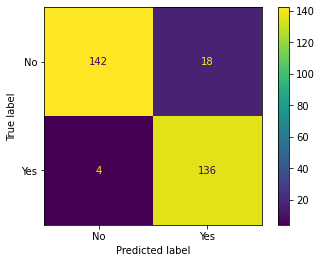

In [148]:
model = ensemble.AdaBoostClassifier(n_estimators=2000, learning_rate=0.001, random_state=seed)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

plot_confusion_matrix(model, test_X, test_y, display_labels=['No', 'Yes'])

train_acc = model.score(train_X, train_y)
test_acc = model.score(test_X, test_y)
precision = precision_score(test_y, pred_y)
print(f'Train error rate: {1 - train_acc:.3f}')
print(f'Test error rate: {1 - test_acc:.3f}')
print(f'Test precision: {precision:.3f}')

Train error rate: 0.130
Test error rate: 0.100
Test precision: 0.857


array([[ 0.04469931,  0.00034788, -0.05373053, -0.03386278, -0.24439637,
         0.        ,  0.        ,  0.00412264,  0.        ,  0.        ,
         0.        ]])

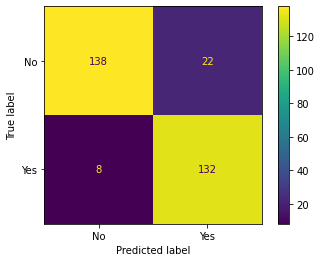

In [163]:
model = LogisticRegression(penalty='l1', C=.1, solver='liblinear')
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

plot_confusion_matrix(model, test_X, test_y, display_labels=['No', 'Yes'])

train_acc = model.score(train_X, train_y)
test_acc = model.score(test_X, test_y)
precision = precision_score(test_y, pred_y)
print(f'Train error rate: {1 - train_acc:.3f}')
print(f'Test error rate: {1 - test_acc:.3f}')
print(f'Test precision: {precision:.3f}')
model.coef_

It is seen that ensemble methods are much better than logistic regression with lasso shrinkage. Bagging has the best test accuracy and precision.